In [19]:
import pandas as pd

In [20]:
from pandas.plotting import scatter_matrix

In [21]:
crop = pd.read_csv("/content/sample_data/crop_production.csv")
rain=pd.read_csv("/content/sample_data/rainfall in india 1901-2015.csv")

In [22]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB


In [23]:
numeric = crop.select_dtypes(include=['int64', 'float64']).columns


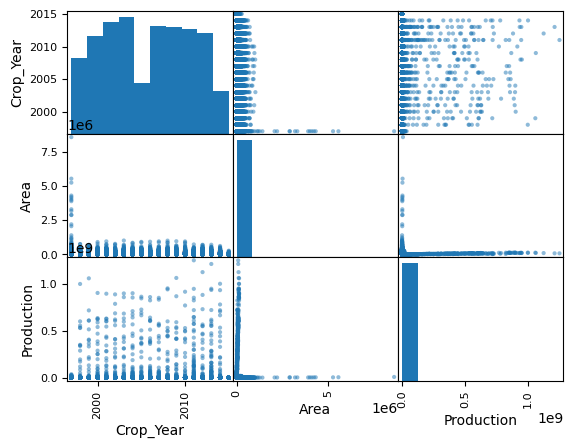

In [24]:
axs=scatter_matrix(crop[numeric])

In [25]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4112 non-null   float64
 3   FEB          4113 non-null   float64
 4   MAR          4110 non-null   float64
 5   APR          4112 non-null   float64
 6   MAY          4113 non-null   float64
 7   JUN          4111 non-null   float64
 8   JUL          4109 non-null   float64
 9   AUG          4112 non-null   float64
 10  SEP          4110 non-null   float64
 11  OCT          4109 non-null   float64
 12  NOV          4105 non-null   float64
 13  DEC          4106 non-null   float64
 14  ANNUAL       4090 non-null   float64
 15  Jan-Feb      4110 non-null   float64
 16  Mar-May      4107 non-null   float64
 17  Jun-Sep      4106 non-null   float64
 18  Oct-Dec      4103 non-null   float64
dtypes: flo

In [26]:
numeric=rain.select_dtypes(include="number").columns

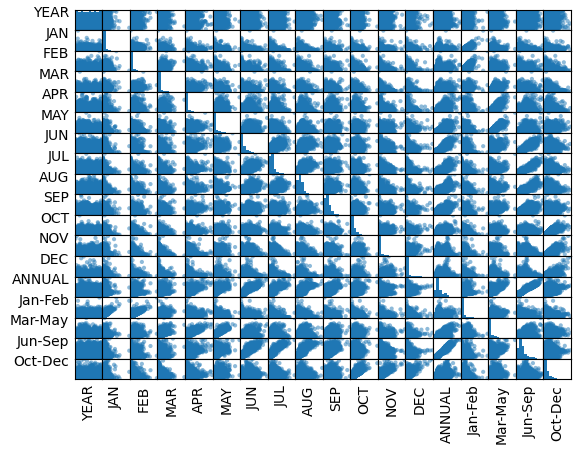

In [27]:
axs=scatter_matrix(rain[numeric])
n=len(numeric)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [28]:
#!pip install duckdb

In [29]:
import pandas as pd
import duckdb
import os

DATABASE_FILE = "samarth.db"
AGRI_SOURCE_URL = "https://data.gov.in/resource/district-wise-season-wise-crop-production-statistics-1997"
RAIN_SOURCE_URL = "https://data.gov.in/resource/area-weighted-monthly-seasonal-and-annual-rainfall-mm-36-meteorological-subdivisions-1901"

SUBDIVISION_TO_STATE_MAP = {
    "ANDAMAN & NICOBAR ISLANDS": "Andaman & Nicobar Islands",
    "ARUNACHAL PRADESH": "Arunachal Pradesh",
    "ASSAM & MEGHALAYA": "Assam",
    "NAGA MANI MIZO TRIPURA": "Nagaland",
    "SUB HIMALAYAN WEST BENGAL": "West Bengal",
    "GANGETIC WEST BENGAL": "West Bengal",
    "ORISSA": "Odisha",
    "JHARKHAND": "Jharkhand",
    "BIHAR": "Bihar",
    "UTTAR PRADESH EAST": "Uttar Pradesh",
    "UTTAR PRADESH WEST": "Uttar Pradesh",
    "UTTARAKHAND": "Uttarakhand",
    "HARYANA DELHI & CHANDIGARH": "Haryana",
    "PUNJAB": "Punjab",
    "HIMACHAL PRADESH": "Himachal Pradesh",
    "JAMMU & KASHMIR": "Jammu & Kashmir",
    "RAJASTHAN WEST": "Rajasthan",
    "RAJASTHAN EAST": "Rajasthan",
    "MADHYA PRADESH WEST": "Madhya Pradesh",
    "MADHYA PRADESH EAST": "Madhya Pradesh",
    "GUJARAT REGION": "Gujarat",
    "SAURASHTRA & KUTCH": "Gujarat",
    "KONKAN & GOA": "Goa",
    "MADHYA MAHARASHTRA": "Maharashtra",
    "MARATHWADA": "Maharashtra",
    "VIDARBHA": "Maharashtra",
    "CHHATTISGARH": "Chhattisgarh",
    "COASTAL ANDHRA PRADESH": "Andhra Pradesh",
    "TELANGANA": "Telangana",
    "RAYALSEEMA": "Andhra Pradesh",
    "TAMIL NADU & PUDUCHERRY": "Tamil Nadu",
    "COASTAL KARNATAKA": "Karnataka",
    "NORTH INTERIOR KARNATAKA": "Karnataka",
    "SOUTH INTERIOR KARNATAKA": "Karnataka",
    "KERALA": "Kerala",
    "LAKSHADWEEP": "Lakshadweep"
}

def clean_agriculture_data(df):
    print("Cleaning raw 'crop' DataFrame...")
    df_clean = df.copy()

    df_clean.rename(columns={
        "State_Name": "State",
        "District_Name": "District",
        "Crop_Year": "Year",
        "Production": "Production_Tonnes"
    }, inplace=True)

    df_clean['State'] = df_clean['State'].str.title().str.strip()
    df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
    df_clean.dropna(subset=['State', 'District', 'Year', 'Crop', 'Production_Tonnes'], inplace=True)

    df_final = df_clean[['State', 'District', 'Year', 'Crop', 'Production_Tonnes']].copy()
    print(f"Cleaned 'crop' data. {len(df_final)} rows remaining.")
    return df_final

def clean_rainfall_data(df):
    print("Cleaning raw 'rain' DataFrame...")
    df_clean = df.copy()

    df_clean.rename(columns={
        "SUBDIVISION": "Subdivision",
        "YEAR": "Year",
        "ANNUAL": "Annual_Rainfall_mm"
    }, inplace=True)

    df_clean['State'] = df_clean['Subdivision'].map(SUBDIVISION_TO_STATE_MAP)
    df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
    df_subset = df_clean[['State', 'Year', 'Annual_Rainfall_mm']].copy()

    print("Aggregating rainfall data by state and year...")
    df_agg = df_subset.groupby(['State', 'Year'])['Annual_Rainfall_mm'].sum().reset_index()

    df_agg.dropna(subset=['State', 'Year'], inplace=True)
    print(f"Cleaned and aggregated 'rain' data. {len(df_agg)} rows remaining.")
    return df_agg

def create_database(cleaned_crop_df, cleaned_rain_df):
    if os.path.exists(DATABASE_FILE):
        os.remove(DATABASE_FILE)
        print(f"Removed old database: {DATABASE_FILE}")

    print(f"Creating new database: {DATABASE_FILE}...")
    con = duckdb.connect(database=DATABASE_FILE, read_only=False)

    print("Creating table 'crop_production'...")
    con.sql(f"""
        CREATE TABLE crop_production AS
        SELECT *, '{AGRI_SOURCE_URL}' AS source_url
        FROM cleaned_crop_df
    """)

    print("Creating table 'rainfall'...")
    con.sql(f"""
        CREATE TABLE rainfall AS
        SELECT *, '{RAIN_SOURCE_URL}' AS source_url
        FROM cleaned_rain_df
    """)

    print("\n--- Database Verification ---")
    print("Tables in database:")
    con.sql("SHOW TABLES").show()

    print("\nSample from 'crop_production':")
    con.sql("SELECT * FROM crop_production LIMIT 3").show()

    print("\nSample from 'rainfall':")
    con.sql("SELECT * FROM rainfall LIMIT 3").show()

    con.close()
    print(f"\nSuccess! Your database is ready in the file: {DATABASE_FILE}")

#  SCRIPT EXECUTION


try:
    cleaned_crop = clean_agriculture_data(crop)
    cleaned_rain = clean_rainfall_data(rain)
    create_database(cleaned_crop, cleaned_rain)

except NameError as e:
    print(f"ERROR: A DataFrame variable was not found. {e}")
    print("Please make sure your raw data is loaded into variables named 'crop' and 'rain'.")
except Exception as e:
    print(f"An error occurred: {e}")

Cleaning raw 'crop' DataFrame...
Cleaned 'crop' data. 242361 rows remaining.
Cleaning raw 'rain' DataFrame...
Aggregating rainfall data by state and year...
Cleaned and aggregated 'rain' data. 2506 rows remaining.
Creating new database: samarth.db...
Creating table 'crop_production'...
Creating table 'rainfall'...

--- Database Verification ---
Tables in database:
┌─────────────────┐
│      name       │
│     varchar     │
├─────────────────┤
│ crop_production │
│ rainfall        │
└─────────────────┘


Sample from 'crop_production':
┌─────────────────────────────┬──────────┬───────┬─────────────────────┬───────────────────┬────────────────────────────────────────────────────────────────────────────────────────┐
│            State            │ District │ Year  │        Crop         │ Production_Tonnes │                                       source_url                                       │
│           varchar           │ varchar  │ int64 │       varchar       │      double       │    